In [2]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "/mnt/c/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
# NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

## Get training data for each model

In [3]:
## Replace with v2 when Chansey is back up :/
kiran_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov2_allmodels.csv")
kiran_data = utils.prep_nlst_preds(kiran_nodule, scanlevel=True, sybil=False, tijmen=False)
print(len(kiran_data), "Scans")

10183 Scans


In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v2_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [18]:
nlst_democols['cat'].pop('nodule')
nlst_democols['num'].pop('nodule')
nlst_democols['num'].pop('other')
nlst_democols

{'num': {'demo': ['height', 'weight', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']},
 'cat': {'demo': ['marital',
   'educat',
   'race',
   'ethnic',
   'Gender',
   'Married',
   'NonHispanicWhite',
   'HighSchoolPlus'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpanc',
   'cancphar',
   'cancstom',
   'cancthyr',
   'canctran'

In [19]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_list = cols_num + cols_cat

Get data for Tijmen's linear layer.

In [10]:
tijmen_train = kiran_data[kiran_data['Thijmen_mean'].isna()]
print("train:", len(tijmen_train), "Scans")
tijmen_val = kiran_data[~kiran_data['Thijmen_mean'].isna()]
print("val:", len(tijmen_val), "Scans")

train: 8121 Scans
val: 2062 Scans


In [9]:
sybil_demos = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-split-demos.csv")
sybil_demos.nunique()

id                   41280
split                    3
pid                  14185
timepoint                3
SeriesInstanceUID    41280
                     ...  
wrkbaki                  2
cancoral                 2
wrkweld                  2
wrkchem                  2
study                    3
Length: 74, dtype: int64

In [12]:
sybil_train = sybil_demos.query('split == "train"')
print(len(sybil_train), 'Scans')

28160 Scans


In [13]:
training_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_train,
    'Sybil': sybil_train
}

## Get Demographic splits (train)

In [80]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=training_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

### Categorical columns

In [57]:
def cat_dist_df(c='Gender', dfsets=training_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)

    df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [81]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, training_sets)

In [82]:
display(cat_demo_splits.sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
195,other,PersonalCancerHist,1.0,2962.0,29.0877,2373.0,29.2205,1088.0,3.8636,-0.1328,25.2241,25.3569
193,other,FamilyHistoryLungCa,1.0,2622.0,25.7488,2110.0,25.9820,6232.0,22.1307,-0.2332,3.6181,3.8513
45,smoke,cigsmok,1.0,5088.0,49.9656,4028.0,49.5998,13386.0,47.5355,0.3658,2.4301,2.0643
41,smoke,cigar,0.0,8215.0,80.6737,6544.0,80.5812,22137.0,78.6115,0.0925,2.0622,1.9697
119,disease,diagemph,1.0,1022.0,10.0363,817.0,10.0603,2317.0,8.2280,-0.0240,1.8083,1.8323
34,demo,Gender,2.0,4349.0,42.7084,3466.0,42.6795,11588.0,41.1506,0.0289,1.5578,1.5289
10,demo,educat,3.0,2538.0,24.9239,2001.0,24.6398,6581.0,23.3700,0.2841,1.5539,1.2698
113,disease,diagcopd,1.0,676.0,6.6385,533.0,6.5632,1477.0,5.2450,0.0753,1.3935,1.3182
2,demo,marital,3.0,864.0,8.4847,659.0,8.1148,2055.0,7.2976,0.3699,1.1871,0.8172
35,demo,Married,0.0,3328.0,32.6819,2654.0,32.6807,8878.0,31.5270,0.0012,1.1549,1.1537


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
194,other,PersonalCancerHist,0.0,7221.0,70.9123,5748.0,70.7795,27072.0,96.1364,0.1328,-25.2241,-25.3569
192,other,FamilyHistoryLungCa,0.0,7561.0,74.2512,6011.0,74.0180,21928.0,77.8693,0.2332,-3.6181,-3.8513
44,smoke,cigsmok,0.0,5095.0,50.0344,4093.0,50.4002,14774.0,52.4645,-0.3658,-2.4301,-2.0643
42,smoke,cigar,1.0,1934.0,18.9924,1550.0,19.0863,5942.0,21.1009,-0.0939,-2.1085,-2.0146
118,disease,diagemph,0.0,9136.0,89.7182,7283.0,89.6811,25788.0,91.5767,0.0371,-1.8585,-1.8956
13,demo,educat,6.0,1585.0,15.5652,1253.0,15.4291,4836.0,17.1733,0.1361,-1.6081,-1.7442
33,demo,Gender,1.0,5834.0,57.2916,4655.0,57.3205,16572.0,58.8494,-0.0289,-1.5578,-1.5289
112,disease,diagcopd,0.0,9479.0,93.0865,7563.0,93.1289,26604.0,94.4744,-0.0424,-1.3879,-1.3455
1,demo,marital,2.0,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
36,demo,Married,1.0,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537


In [101]:
display(cat_demo_splits.query('category == "canchist"').sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.query('category == "canchist"').sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
149,canchist,cancbrea,1.0,159.0,1.5614,129.0,1.5885,355.0,1.2607,-0.0271,0.3007,0.3278
146,canchist,cancblad,1.0,66.0,0.6481,53.0,0.6526,109.0,0.3871,-0.0045,0.2610,0.2655
155,canchist,canccolo,1.0,49.0,0.4812,43.0,0.5295,101.0,0.3587,-0.0483,0.1225,0.1708
189,canchist,canctran,NaN,22.0,0.2160,15.0,0.1847,27.0,0.0959,0.0313,0.1201,0.0888
171,canchist,cancnasa,NaN,19.0,0.1866,17.0,0.2093,21.0,0.0746,-0.0227,0.1120,0.1347
182,canchist,cancstom,1.0,12.0,0.1178,9.0,0.1108,6.0,0.0213,0.0070,0.0965,0.0895
147,canchist,cancblad,NaN,17.0,0.1669,15.0,0.1847,21.0,0.0746,-0.0178,0.0923,0.1101
159,canchist,cancesop,NaN,14.0,0.1375,12.0,0.1478,15.0,0.0533,-0.0103,0.0842,0.0945
180,canchist,cancphar,NaN,14.0,0.1375,12.0,0.1478,15.0,0.0533,-0.0103,0.0842,0.0945
165,canchist,canclary,NaN,14.0,0.1375,12.0,0.1478,15.0,0.0533,-0.0103,0.0842,0.0945


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
148,canchist,cancbrea,0.0,10007.0,98.2716,7977.0,98.2268,27775.0,98.6328,0.0448,-0.3612,-0.4060
145,canchist,cancblad,0.0,10100.0,99.1849,8053.0,99.1627,28030.0,99.5384,0.0222,-0.3535,-0.3757
154,canchist,canccolo,0.0,10120.0,99.3813,8066.0,99.3227,28041.0,99.5774,0.0586,-0.1961,-0.2547
181,canchist,cancstom,0.0,10157.0,99.7447,8100.0,99.7414,28139.0,99.9254,0.0033,-0.1807,-0.1840
157,canchist,cancesop,0.0,10159.0,99.7643,8103.0,99.7784,28139.0,99.9254,-0.0141,-0.1611,-0.1470
151,canchist,canccerv,0.0,10017.0,98.3698,7997.0,98.4731,27743.0,98.5192,-0.1033,-0.1494,-0.0461
169,canchist,cancnasa,0.0,10157.0,99.7447,8097.0,99.7045,28124.0,99.8722,0.0402,-0.1275,-0.1677
163,canchist,canclary,0.0,10161.0,99.7840,8107.0,99.8276,28132.0,99.9006,-0.0436,-0.1166,-0.0730
178,canchist,cancphar,0.0,10166.0,99.8331,8109.0,99.8522,28145.0,99.9467,-0.0191,-0.1136,-0.0945
160,canchist,canckidn,0.0,10156.0,99.7349,8099.0,99.7291,28115.0,99.8402,0.0058,-0.1053,-0.1111


In [83]:
display(cat_demo_splits.query('category == "demo"').sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.query('category == "demo"').sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
34,demo,Gender,2.0,4349.0,42.7084,3466.0,42.6795,11588.0,41.1506,0.0289,1.5578,1.5289
10,demo,educat,3.0,2538.0,24.9239,2001.0,24.6398,6581.0,23.3700,0.2841,1.5539,1.2698
2,demo,marital,3.0,864.0,8.4847,659.0,8.1148,2055.0,7.2976,0.3699,1.1871,0.8172
35,demo,Married,0.0,3328.0,32.6819,2654.0,32.6807,8878.0,31.5270,0.0012,1.1549,1.1537
38,demo,NonHispanicWhite,1.0,9311.0,91.4367,7402.0,91.1464,25461.0,90.4155,0.2903,1.0212,0.7309
18,demo,race,1.0,9461.0,92.9098,7528.0,92.6979,25919.0,92.0419,0.2119,0.8679,0.6560
9,demo,educat,2.0,518.0,5.0869,401.0,4.9378,1265.0,4.4922,0.1491,0.5947,0.4456
8,demo,educat,1.0,164.0,1.6105,122.0,1.5023,353.0,1.2536,0.1082,0.3569,0.2487
39,demo,HighSchoolPlus,0.0,164.0,1.6105,122.0,1.5023,353.0,1.2536,0.1082,0.3569,0.2487
14,demo,educat,7.0,1465.0,14.3867,1156.0,14.2347,3976.0,14.1193,0.1520,0.2674,0.1154


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
13,demo,educat,6.0,1585.0,15.5652,1253.0,15.4291,4836.0,17.1733,0.1361,-1.6081,-1.7442
33,demo,Gender,1.0,5834.0,57.2916,4655.0,57.3205,16572.0,58.8494,-0.0289,-1.5578,-1.5289
1,demo,marital,2.0,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
36,demo,Married,1.0,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
12,demo,educat,5.0,2287.0,22.4590,1858.0,22.8790,6647.0,23.6044,-0.4200,-1.1454,-0.7254
37,demo,NonHispanicWhite,0.0,872.0,8.5633,719.0,8.8536,2699.0,9.5845,-0.2903,-1.0212,-0.7309
0,demo,marital,1.0,416.0,4.0852,338.0,4.1620,1274.0,4.5241,-0.0768,-0.4389,-0.3621
20,demo,race,3.0,169.0,1.6596,146.0,1.7978,575.0,2.0419,-0.1382,-0.3823,-0.2441
19,demo,race,2.0,338.0,3.3193,274.0,3.3740,1036.0,3.6790,-0.0547,-0.3597,-0.3050
40,demo,HighSchoolPlus,1.0,10019.0,98.3895,7999.0,98.4977,27807.0,98.7464,-0.1082,-0.3569,-0.2487


### Numerical columns

In [87]:
def num_dist_df(c='Gender', dfsets=training_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min'], inplace=True)
    return df

In [88]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, training_sets)

In [89]:
display(num_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=False).query('diff_Kiran_Sybil > 0'))
num_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=True).query('diff_Kiran_Sybil < 0')

,category,attribute,value,Kiran,Tijmen,Sybil,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
10,smoke,pkyr,mean,57.9729,57.9599,56.1487,0.0130,1.8242,1.8112
7,demo,Age,mean,63.2049,63.1751,61.6496,0.0298,1.5553,1.5255
19,smoke,smokeyr,mean,41.0055,40.9844,39.9523,0.0211,1.0532,1.0321
18,smoke,smokeyr,50%,41.0000,41.0000,40.0000,0.0000,1.0000,1.0000
6,demo,Age,50%,62.0000,62.0000,61.0000,0.0000,1.0000,1.0000
9,smoke,pkyr,50%,50.0000,50.0000,49.0000,0.0000,1.0000,1.0000
11,smoke,pkyr,std,24.6293,24.9646,23.6767,-0.3353,0.9526,1.2879
17,smoke,smokeday,std,11.4641,11.4674,11.2621,-0.0033,0.2020,0.2053
8,demo,Age,std,5.2401,5.2387,5.0632,0.0014,0.1769,0.1755
16,smoke,smokeday,mean,28.5740,28.5444,28.4474,0.0296,0.1266,0.0970


,category,attribute,value,Kiran,Tijmen,Sybil,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
4,demo,weight,mean,181.8113,181.8669,183.4129,-0.0556,-1.6016,-1.5460
5,demo,weight,std,38.9777,38.9825,39.1290,-0.0048,-0.1513,-0.1465
13,smoke,smokeage,mean,16.5991,16.5993,16.7199,-0.0002,-0.1208,-0.1206
14,smoke,smokeage,std,3.5359,3.5449,3.6027,-0.0090,-0.0668,-0.0578
20,smoke,smokeyr,std,7.3690,7.3377,7.3799,0.0313,-0.0109,-0.0422


### Demographic correlations in the training data

In [90]:
correlations = {m: training_sets[m][cols_list].corr(method='pearson').round(2) for m in training_sets}
correlations['diff_Kiran_Tijmen'] = correlations['Kiran'] - correlations['Tijmen']
correlations['diff_Kiran_Sybil'] = correlations['Kiran'] - correlations['Sybil']

### Kiran

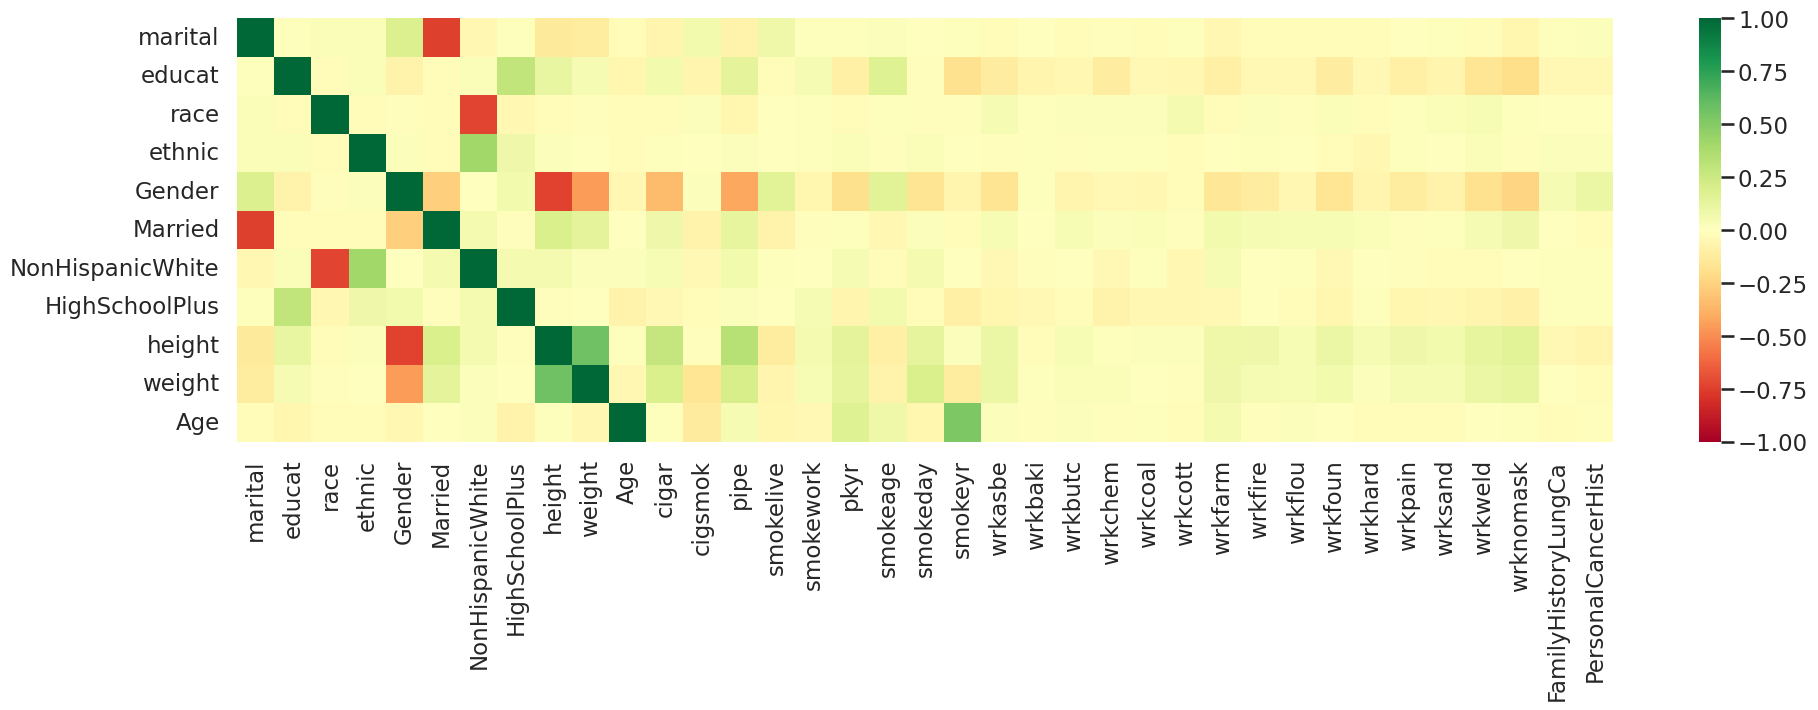

### Tijmen

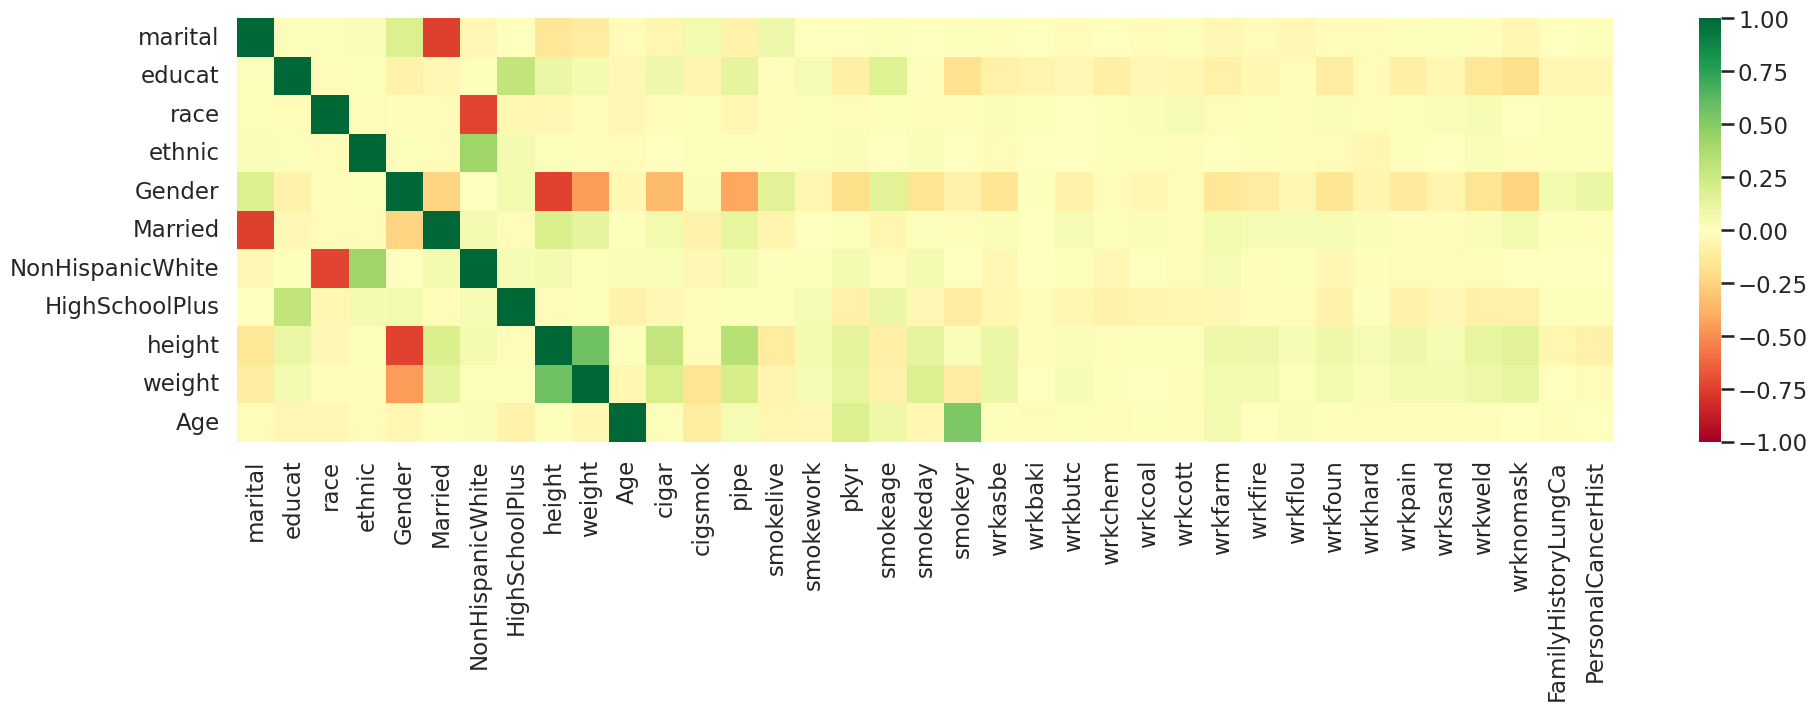

### Sybil

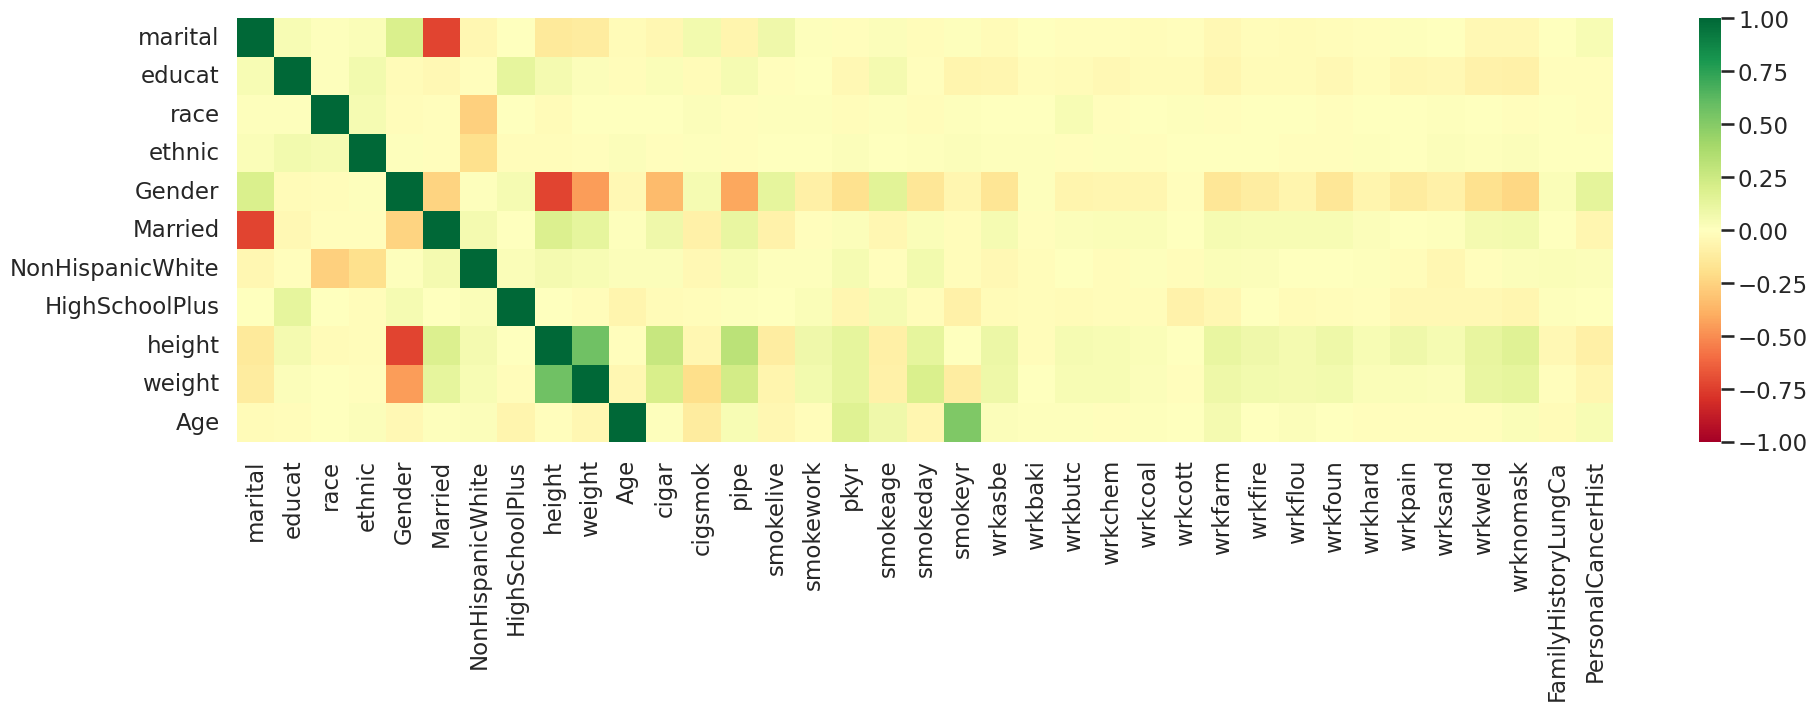

### diff_Kiran_Tijmen

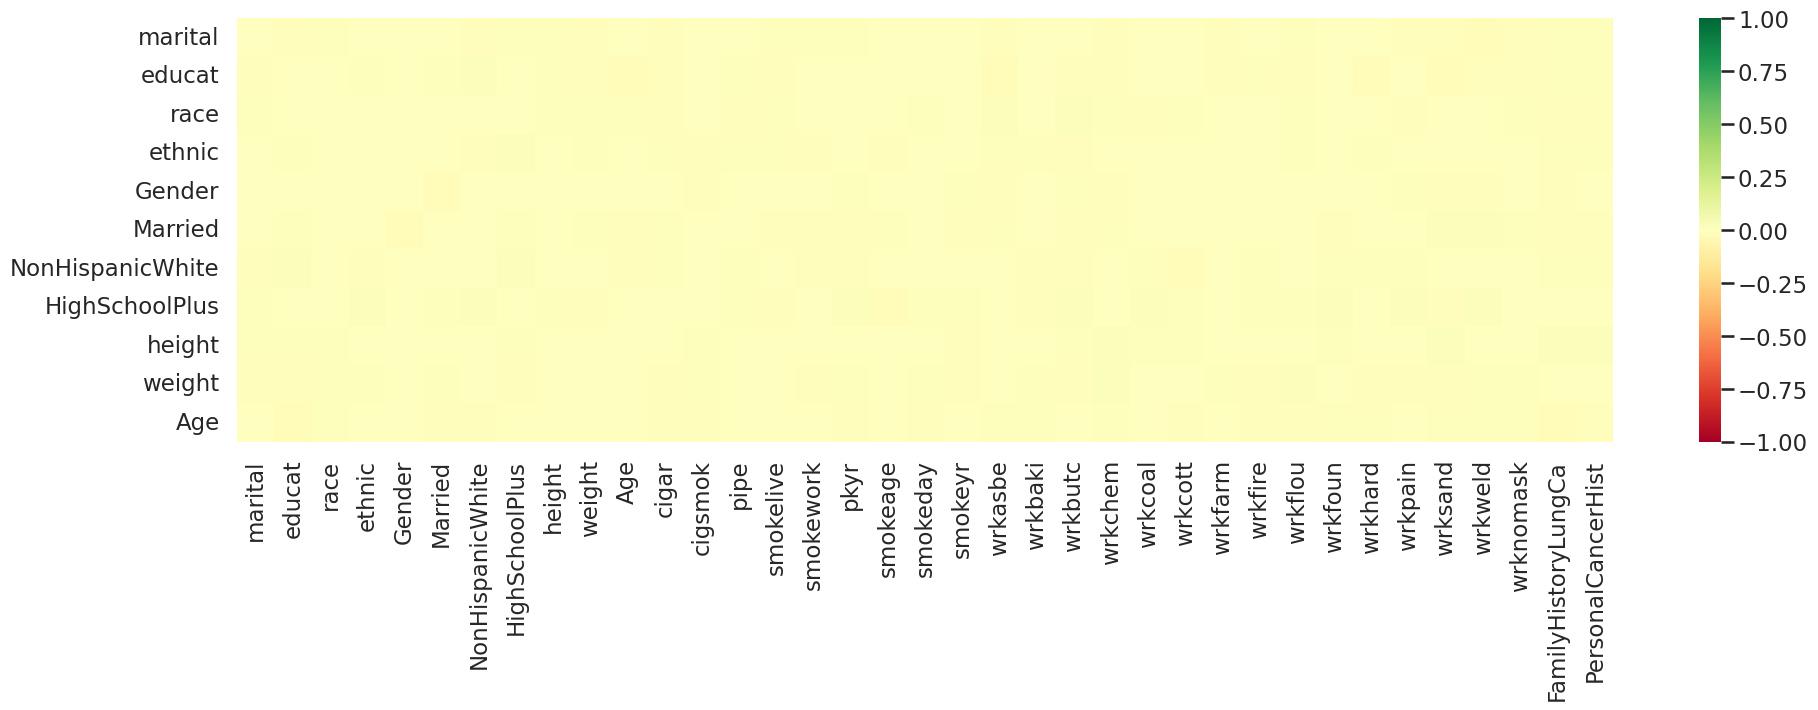

### diff_Kiran_Sybil

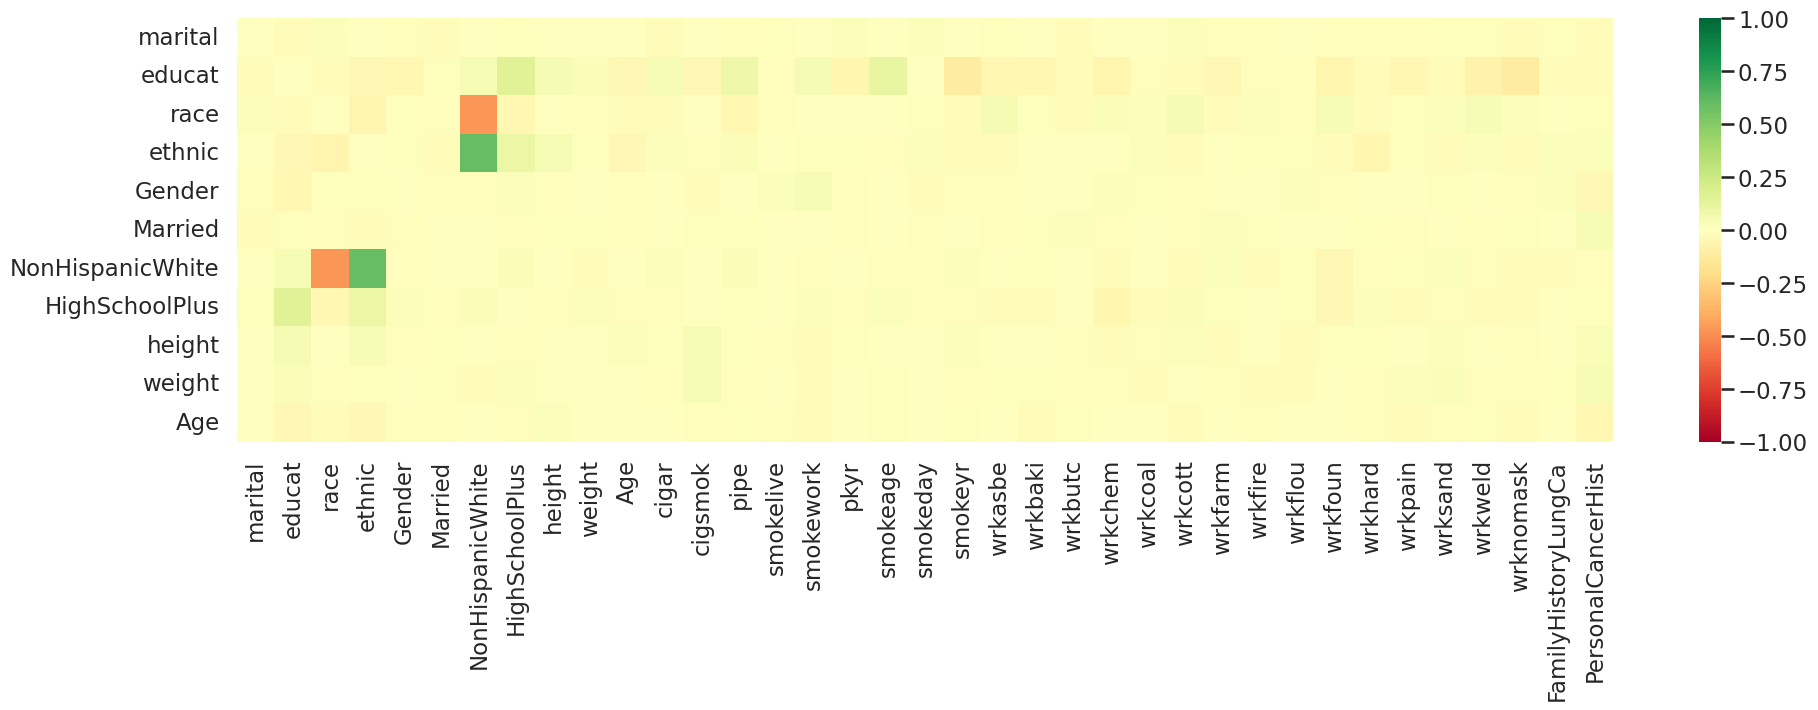

In [91]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['work'] + nlst_democols['cat']['other']
    # corr_cols, corr_rows = cols_list, cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

## Get demo splits (validation)

In [92]:
sybil_val = sybil_demos.query('split == "dev"')
print(len(sybil_val), 'Scans')

6838 Scans


In [93]:
sybil_test = sybil_demos.query('split == "test"')
print(len(sybil_test), 'Scans')

6282 Scans


In [94]:
val_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_val,
    'Sybil': sybil_val,
    'Sybil_test': sybil_test
}

### Categorical columns

In [95]:
cat_demo_val = combine_col_dfs(nlst_democols['cat'], cat_dist_df, val_sets)

In [96]:
display(cat_demo_val.sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_val.sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,Sybil_test_freq,Sybil_test_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Kiran_Sybil_test,diff_norm_Tijmen_Sybil,diff_norm_Tijmen_Sybil_test,diff_norm_Sybil_Sybil_test
194,other,PersonalCancerHist,1.0,2962.0,29.0877,589.0,28.5645,272.0,3.9778,240.0,3.8204,0.5232,25.1099,25.2673,24.5867,24.7441,0.1574
192,other,FamilyHistoryLungCa,1.0,2622.0,25.7488,512.0,24.8303,1469.0,21.4829,1362.0,21.6810,0.9185,4.2659,4.0678,3.3474,3.1493,-0.1981
38,demo,NonHispanicWhite,1.0,9311.0,91.4367,1909.0,92.5800,6076.0,88.8564,5718.0,91.0220,-1.1433,2.5803,0.4147,3.7236,1.5580,-2.1656
45,smoke,cigsmok,1.0,5088.0,49.9656,1060.0,51.4064,3241.0,47.3969,3026.0,48.1694,-1.4408,2.5687,1.7962,4.0095,3.2370,-0.7725
18,demo,race,1.0,9461.0,92.9098,1933.0,93.7439,6201.0,90.6844,5783.0,92.0567,-0.8341,2.2254,0.8531,3.0595,1.6872,-1.3723
41,smoke,cigar,0.0,8215.0,80.6737,1671.0,81.0378,5376.0,78.6195,4889.0,77.8255,-0.3641,2.0542,2.8482,2.4183,3.2123,0.7940
119,disease,diagemph,1.0,1022.0,10.0363,205.0,9.9418,576.0,8.4235,484.0,7.7046,0.0945,1.6128,2.3317,1.5183,2.2372,0.7189
113,disease,diagcopd,1.0,676.0,6.6385,143.0,6.9350,345.0,5.0453,334.0,5.3168,-0.2965,1.5932,1.3217,1.8897,1.6182,-0.2715
34,demo,Gender,2.0,4349.0,42.7084,883.0,42.8225,2822.0,41.2694,2513.0,40.0032,-0.1141,1.4390,2.7052,1.5531,2.8193,1.2662
2,demo,marital,3.0,864.0,8.4847,205.0,9.9418,487.0,7.1220,478.0,7.6090,-1.4571,1.3627,0.8757,2.8198,2.3328,-0.4870


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,Sybil_test_freq,Sybil_test_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Kiran_Sybil_test,diff_norm_Tijmen_Sybil,diff_norm_Tijmen_Sybil_test,diff_norm_Sybil_Sybil_test
193,other,PersonalCancerHist,0.0,7221.0,70.9123,1473.0,71.4355,6566.0,96.0222,6042.0,96.1796,-0.5232,-25.1099,-25.2673,-24.5867,-24.7441,-0.1574
191,other,FamilyHistoryLungCa,0.0,7561.0,74.2512,1550.0,75.1697,5369.0,78.5171,4920.0,78.3190,-0.9185,-4.2659,-4.0678,-3.3474,-3.1493,0.1981
37,demo,NonHispanicWhite,0.0,872.0,8.5633,153.0,7.4200,762.0,11.1436,564.0,8.9780,1.1433,-2.5803,-0.4147,-3.7236,-1.5580,2.1656
44,smoke,cigsmok,0.0,5095.0,50.0344,1002.0,48.5936,3597.0,52.6031,3256.0,51.8306,1.4408,-2.5687,-1.7962,-4.0095,-3.2370,0.7725
42,smoke,cigar,1.0,1934.0,18.9924,384.0,18.6227,1450.0,21.2050,1376.0,21.9039,0.3697,-2.2126,-2.9115,-2.5823,-3.2812,-0.6989
118,disease,diagemph,0.0,9136.0,89.7182,1853.0,89.8642,6256.0,91.4887,5783.0,92.0567,-0.1460,-1.7705,-2.3385,-1.6245,-2.1925,-0.5680
112,disease,diagcopd,0.0,9479.0,93.0865,1916.0,92.9195,6478.0,94.7353,5930.0,94.3967,0.1670,-1.6488,-1.3102,-1.8158,-1.4772,0.3386
13,demo,educat,6.0,1585.0,15.5652,332.0,16.1009,1177.0,17.2126,1008.0,16.0458,-0.5357,-1.6474,-0.4806,-1.1117,0.0551,1.1668
33,demo,Gender,1.0,5834.0,57.2916,1179.0,57.1775,4016.0,58.7306,3769.0,59.9968,0.1141,-1.4390,-2.7052,-1.5531,-2.8193,-1.2662
47,smoke,pipe,1.0,2221.0,21.8109,457.0,22.1629,1584.0,23.1647,1508.0,24.0051,-0.3520,-1.3538,-2.1942,-1.0018,-1.8422,-0.8404


### Numerical columns

In [97]:
num_demo_val = combine_col_dfs(nlst_democols['num'], num_dist_df, val_sets)

In [98]:
display(num_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
num_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran,Tijmen,Sybil,Sybil_test,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
9,smoke,pkyr,50%,50.0000,51.0000,48.0000,49.5000,-1.0000,2.0000,0.5000,3.0000,1.5000,-1.5000
7,demo,Age,mean,63.2049,63.3225,61.6000,61.5807,-0.1176,1.6049,1.6242,1.7225,1.7418,0.0193
10,smoke,pkyr,mean,57.9729,58.0242,56.4101,57.2229,-0.0513,1.5628,0.7500,1.6141,0.8013,-0.8128
19,smoke,smokeyr,mean,41.0055,41.0887,39.8867,40.1227,-0.0832,1.1188,0.8828,1.2020,0.9660,-0.2360
18,smoke,smokeyr,50%,41.0000,41.0000,40.0000,40.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
6,demo,Age,50%,62.0000,63.0000,61.0000,61.0000,-1.0000,1.0000,1.0000,2.0000,2.0000,0.0000
8,demo,Age,std,5.2401,5.2455,5.0697,5.1267,-0.0054,0.1704,0.1134,0.1758,0.1188,-0.0570
1,demo,height,mean,67.8867,67.9452,67.8172,67.9108,-0.0585,0.0695,-0.0241,0.1280,0.0344,-0.0936
2,demo,height,std,3.9438,3.8041,3.8856,3.9016,0.1397,0.0582,0.0422,-0.0815,-0.0975,-0.0160
16,smoke,smokeday,mean,28.5740,28.6906,28.5390,28.9032,-0.1166,0.0350,-0.3292,0.1516,-0.2126,-0.3642


,category,attribute,value,Kiran,Tijmen,Sybil,Sybil_test,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
4,demo,weight,mean,181.8113,181.5927,183.6606,183.6864,0.2186,-1.8493,-1.8751,-2.0679,-2.0937,-0.0258
5,demo,weight,std,38.9777,38.9676,39.7804,40.1892,0.0101,-0.8027,-1.2115,-0.8128,-1.2216,-0.4088
11,smoke,pkyr,std,24.6293,23.2674,25.1968,24.9038,1.3619,-0.5675,-0.2745,-1.9294,-1.6364,0.2930
17,smoke,smokeday,std,11.4641,11.4531,11.6416,11.9578,0.0110,-0.1775,-0.4937,-0.1885,-0.5047,-0.3162
13,smoke,smokeage,mean,16.5991,16.5984,16.7151,16.6479,0.0007,-0.1160,-0.0488,-0.1167,-0.0495,0.0672
20,smoke,smokeyr,std,7.3690,7.4922,7.4660,7.3897,-0.1232,-0.0970,-0.0207,0.0262,0.1025,0.0763
14,smoke,smokeage,std,3.5359,3.5011,3.6078,3.7029,0.0348,-0.0719,-0.1670,-0.1067,-0.2018,-0.0951
15,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
12,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Demographic correlations

In [99]:
correlations = {m: val_sets[m][cols_list].corr(method='pearson').round(2) for m in val_sets}
corr0 = correlations.copy()    
for i, m1 in enumerate(corr0):
    for j, m2 in enumerate(corr0):
        if j > i:
            correlations[f"diff_{m1}_{m2}"] = correlations[f"{m1}"] - correlations[f"{m2}"]

### Kiran

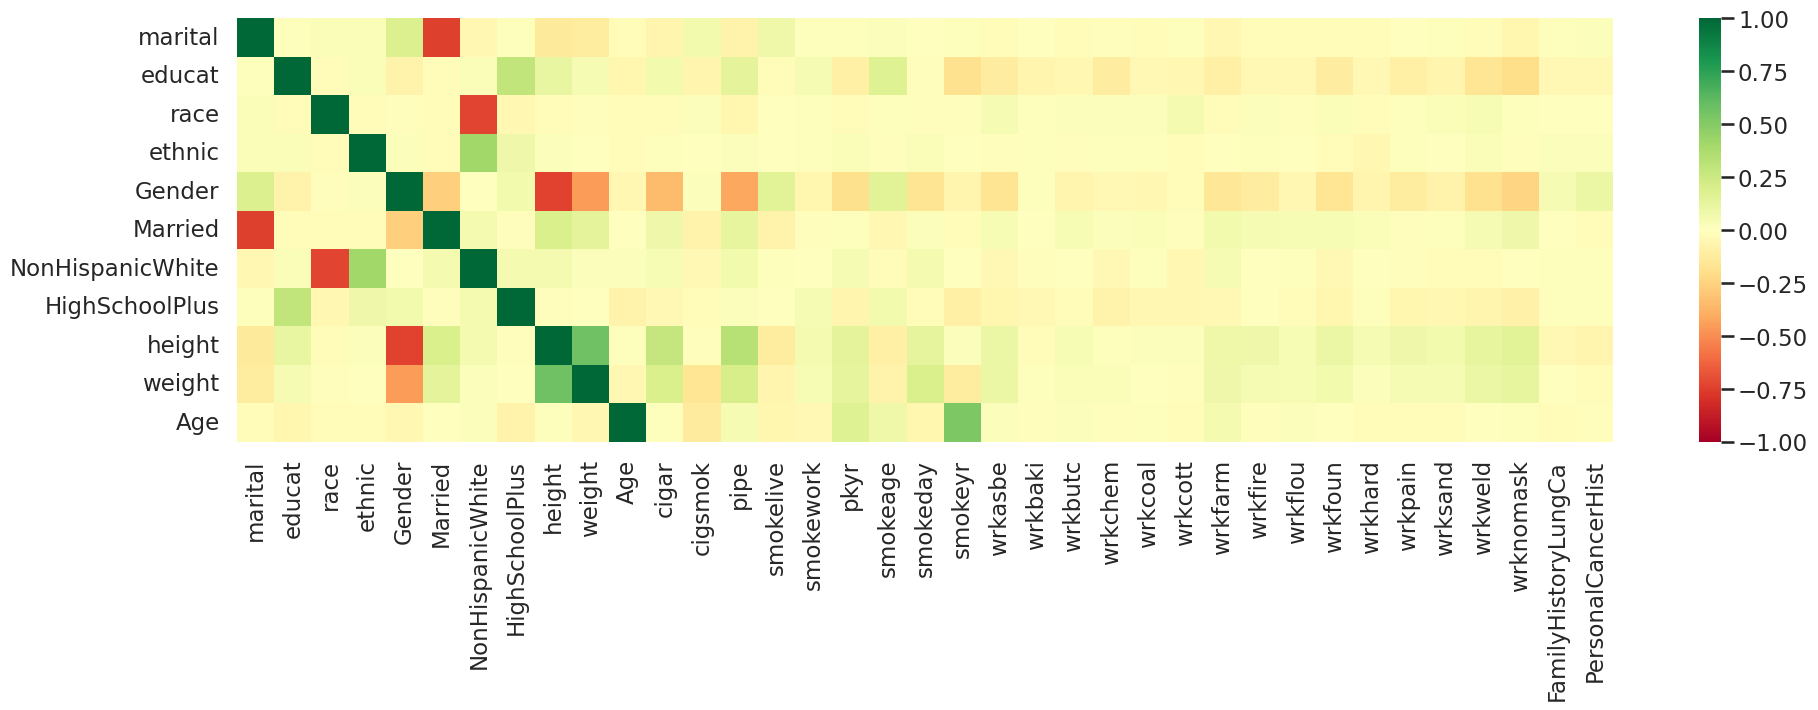

### Tijmen

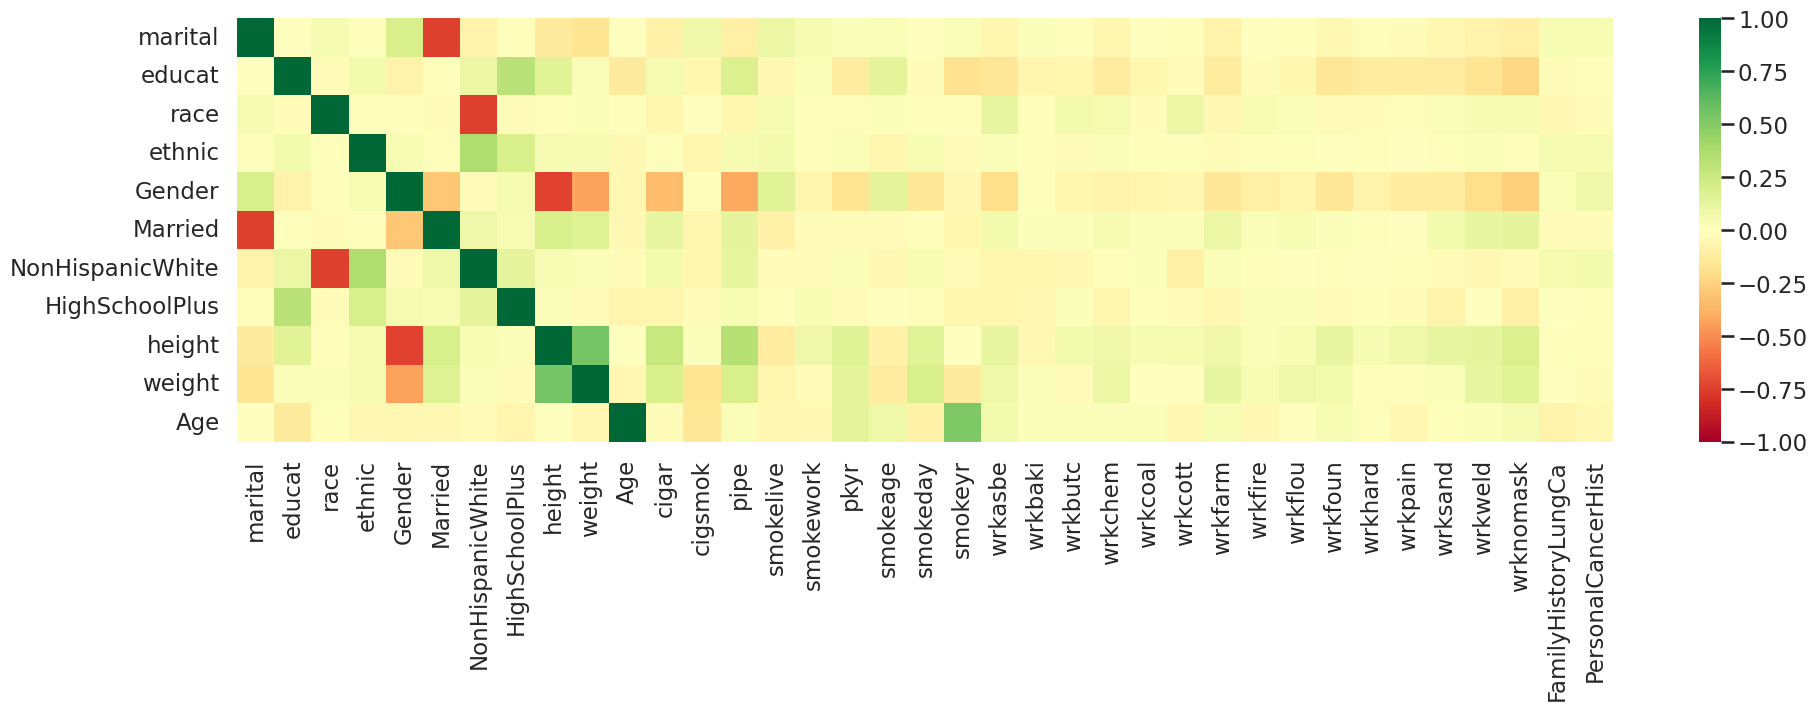

### Sybil

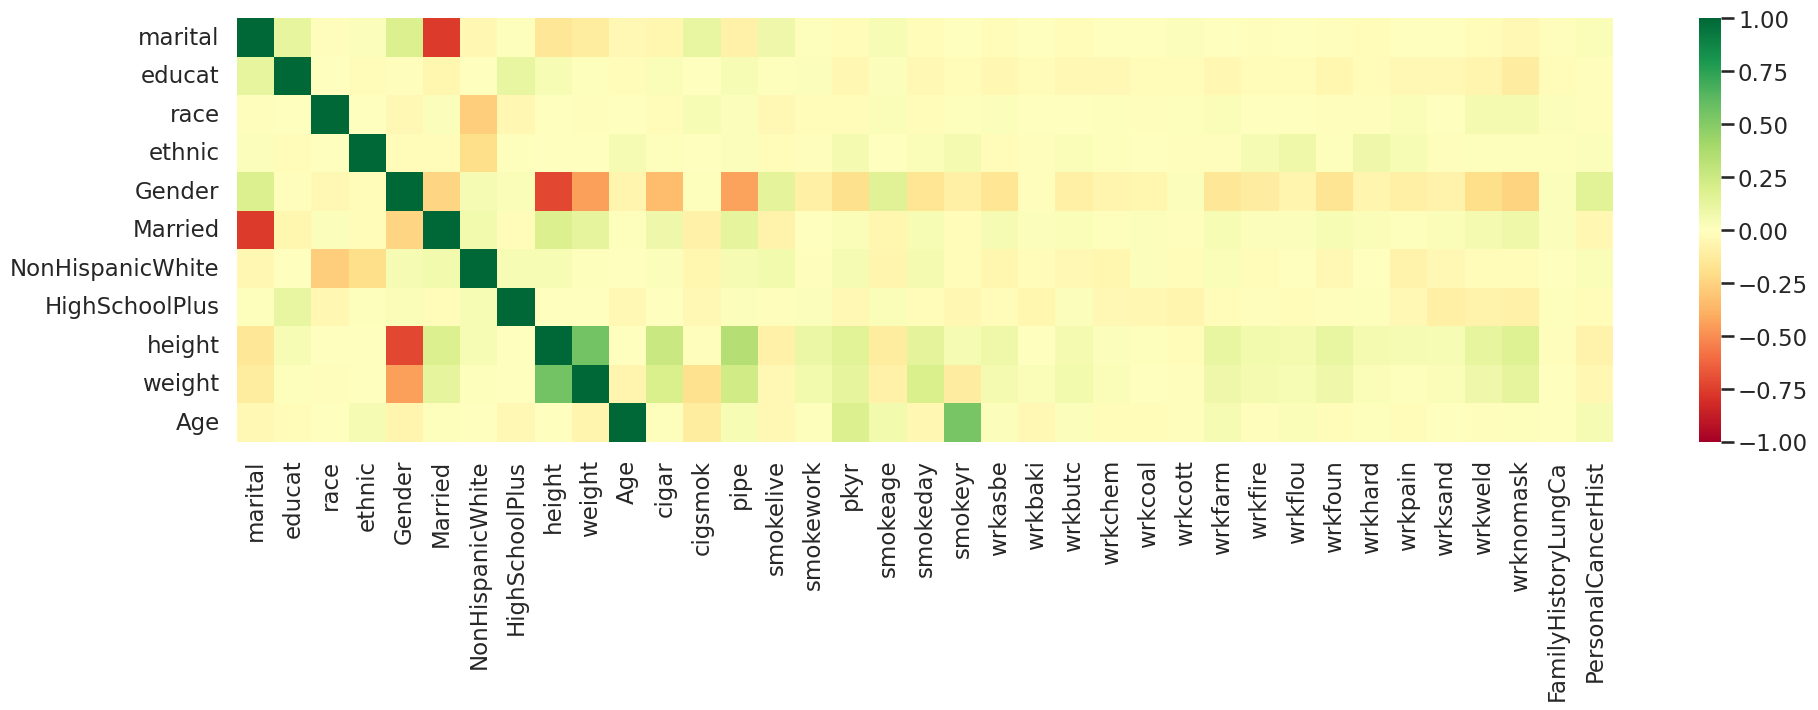

### Sybil_test

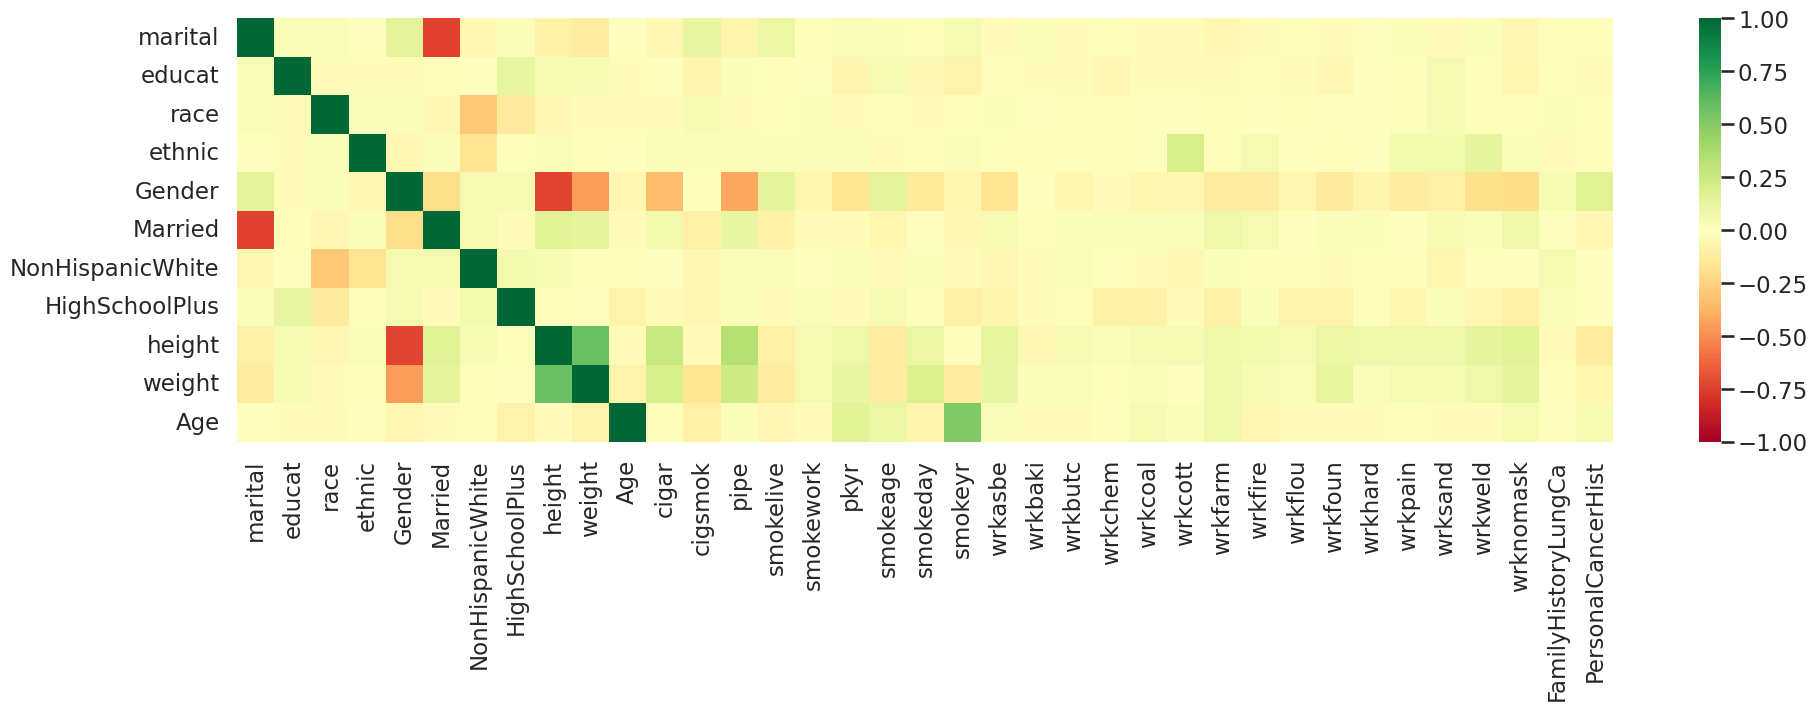

### diff_Kiran_Tijmen

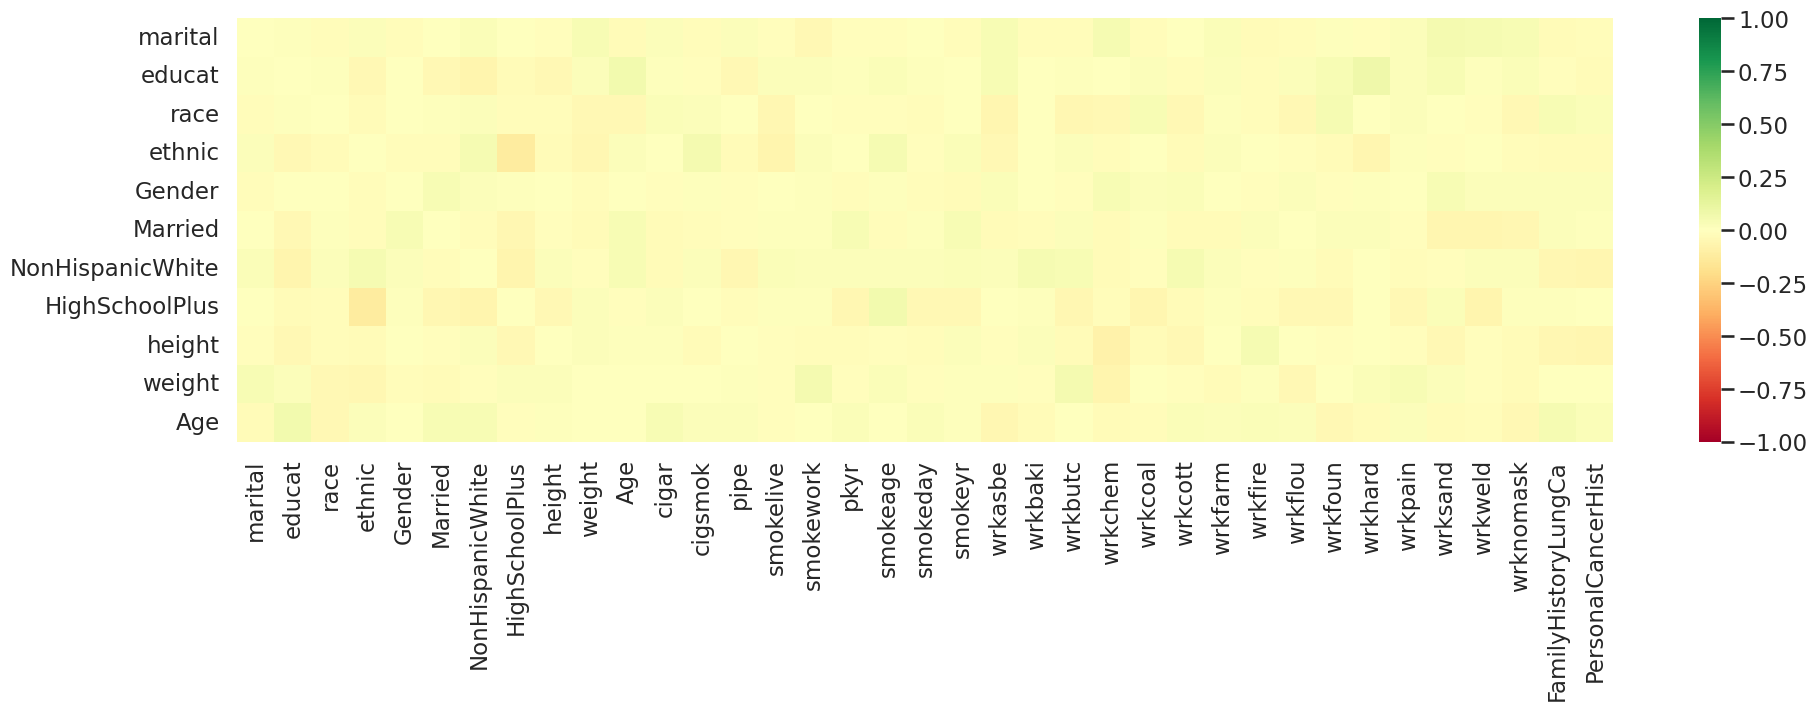

### diff_Kiran_Sybil

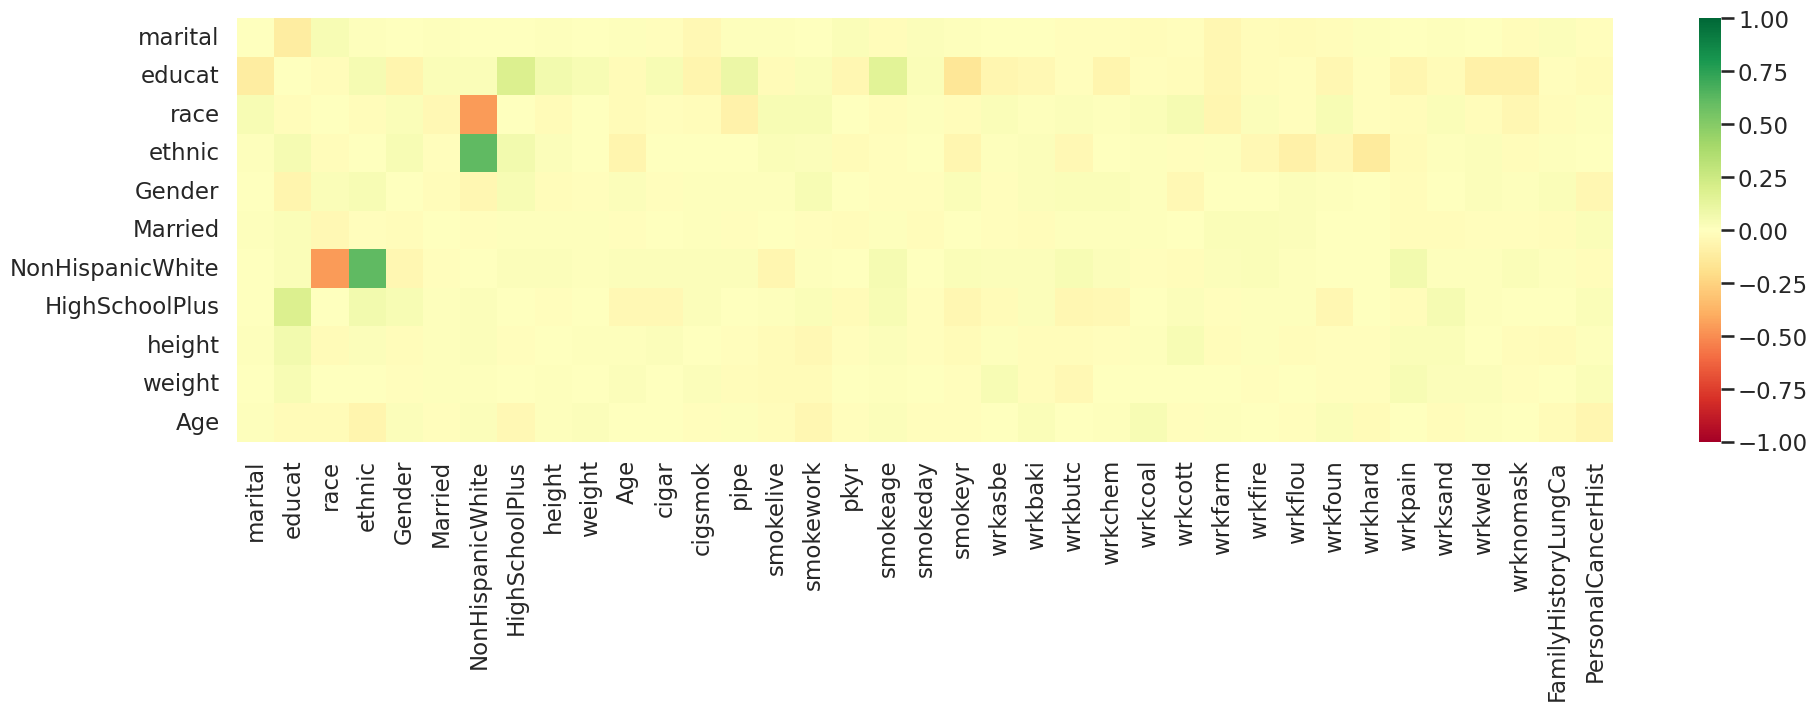

### diff_Kiran_Sybil_test

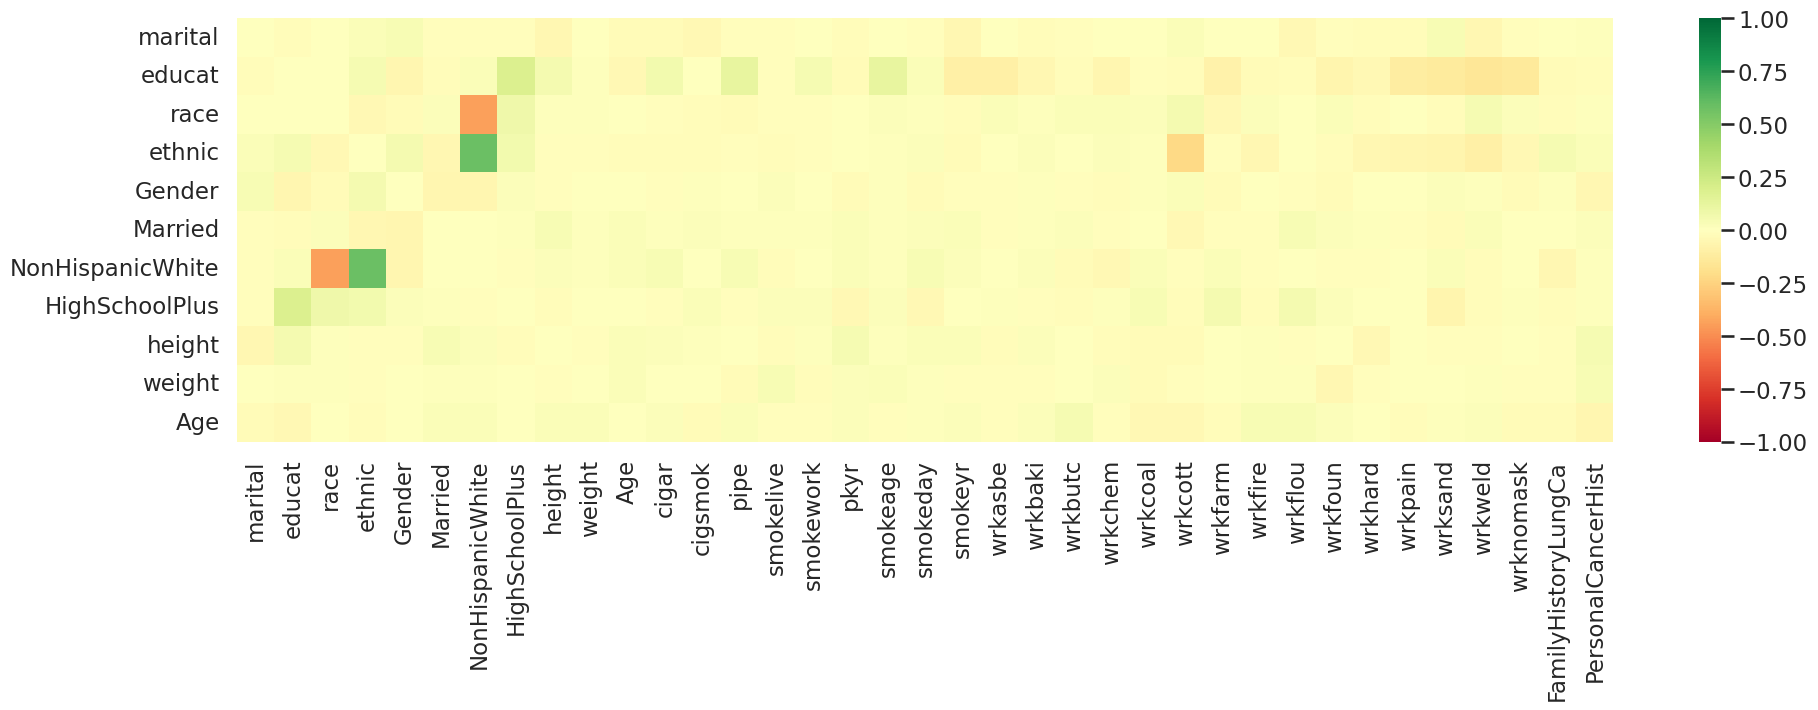

### diff_Tijmen_Sybil

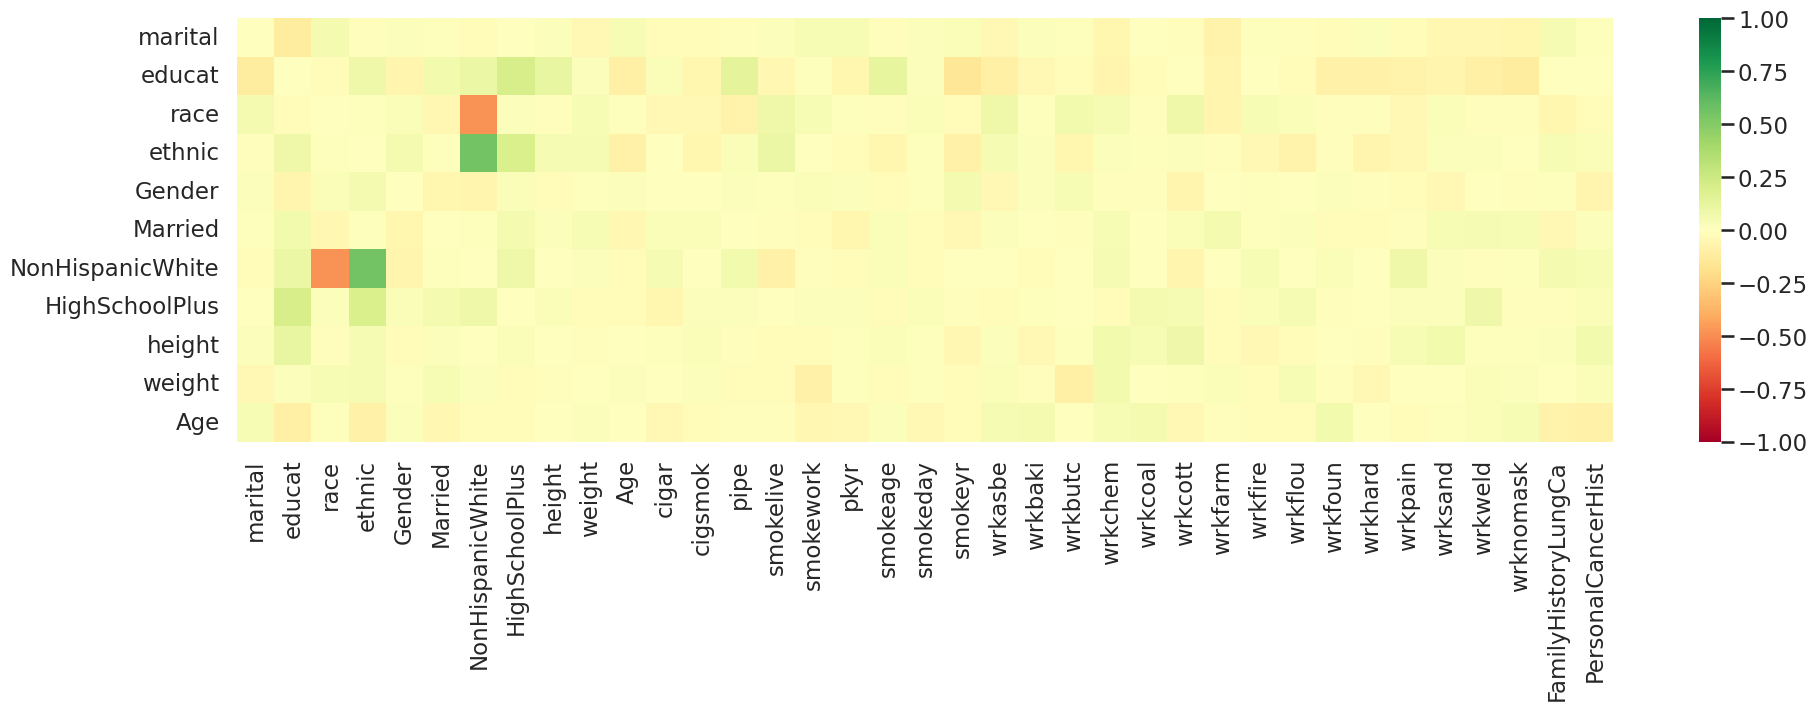

### diff_Tijmen_Sybil_test

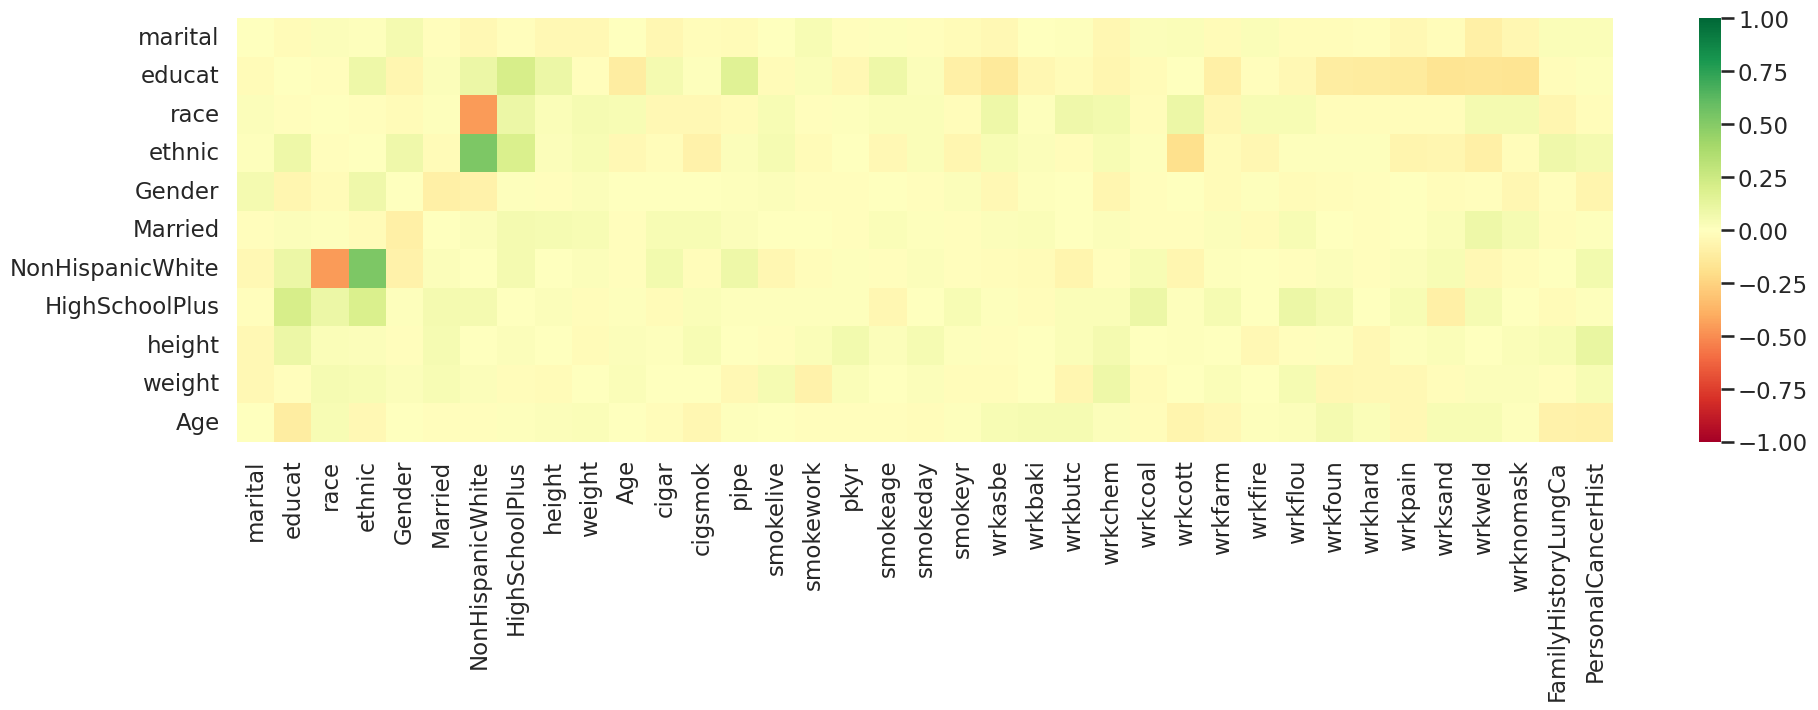

### diff_Sybil_Sybil_test

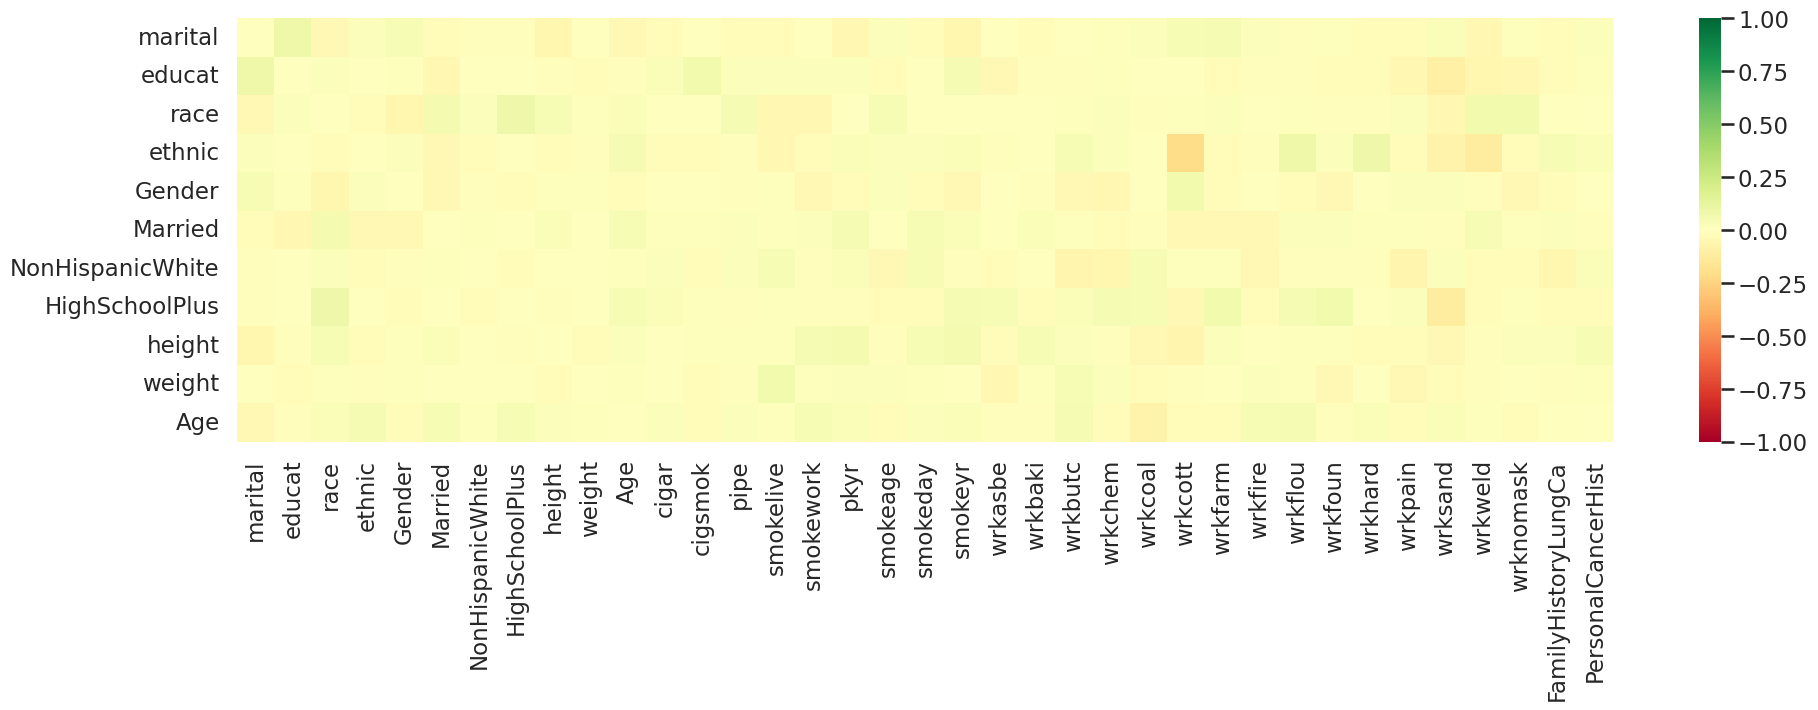

In [100]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['work'] + nlst_democols['cat']['other']
    # corr_cols = cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()